In [1]:
# ----------------------------------------------------------------------------
# SkinCom Analysis - Perform t-test & boxplots for log-ratios
# Author: Sherlyn Weng
# Version: 1.0.0
# Mmaintainer: Sherlyn Weng
# Email: y1weng@ucsd.edu
# This code is adapted from https://github.com/knightlab-analyses/reference-frames
# ----------------------------------------------------------------------------

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from biom import load_table
from scipy.stats import ttest_rel, wilcoxon, ttest_ind, pearsonr, spearmanr
from skbio.stats.composition import multiplicative_replacement
import matplotlib.gridspec as gridspec

from collections import namedtuple

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

"""
Here, we have implemented an extended version of scipy's paired t-test function.
see https://github.com/scipy/scipy/blob/master/scipy/stats/mstats_basic.py#L1085

This should really be pushed to scipy -- any volunteers?
"""
import numpy as np
from scipy.stats import t
from scipy.special import betainc
from collections import namedtuple


Ttest_relResult = namedtuple('Ttest_relResult', 
                             ('statistic', 'pvalue', 'lower_CI', 'upper_CI', 'ddof'))


def ttest_rel(x, y):
    
    D = x - y
    n = len(D)
    
    sd = np.std(D, ddof=1) 
    se = sd / np.sqrt(n)
    mu = np.mean(D)
    T = mu / se
    ddof = n-1
    ci = se * t.ppf( 0.05 / 2, ddof) 
    lower = mu - np.abs(ci)
    upper = mu + np.abs(ci)
    
    prob = betainc(0.5*ddof, 0.5, ddof/(ddof + T*T))
    return Ttest_relResult(T, prob, lower, upper, int(ddof))

In [6]:
def paired_t_test(category, md, df):
    """ Performs paired t-test on a dataframe with complementing
    sample metadata.

    Parameters
    ----------
    category : str
       Category to test in the dataframe df
    md : pd.DataFrame
       Sample metadata specifying groupings
    df : pd.Dataframe
       Counts of microbes across all samples
              
    Returns
    -------
    T : float
       T-statistic
    prob : float
       p-value
    lower : float
       lower 95% CI bound
    upper : float
        upper 95% CI bound
    ddof : int
        degrees of freedom
    """
    cats = list(md[category].value_counts().index)
    src = md[md[category] == cats[0]].index
    print('hio')
    print(src)
    dest = md[md[category] == cats[1]].index
    return ttest_rel(df.loc[dest].values, df.loc[src].values)

## Input Directory

In [7]:
input_dir = "/home/y1weng/02_evonik_batch2/songbird/evonik"

## Variables

In [ ]:
# # load metadata
# metadata = pd.read_table(f'{input_dir}/data/evonik_day0vday4_md.tsv', index_col = 0)
# filtered_metadata = metadata[(metadata['time_treatment'].isin(['post_control', 'post_RL', 'post_SLES'])) &
#          (metadata['individual'].isin(['sub1', 'sub2','sub10', 'sub11', 'sub12', 'sub13', 'sub5', 'sub6', 'sub8', 'sub9'])) 
#         ].sort_values('individual')
# filtered_metadata_rl = metadata[(metadata['time_treatment'].isin(['post_control', 'post_RL', 'post_SLES'])) &
#                                 (metadata['individual'].isin(['sub1', 'sub2', 'sub10', 'sub11', 'sub12', 'sub13', 'sub5', 'sub6', 'sub8', 'sub9'])) & 
#                                 (metadata['individual'].isin(['sub3', 'sub4', 'sub5', 'sub6', 'sub7', 'sub8', 'sub9', 'sub11'])) 
#         ].sort_values('individual')
# filtered_metadata_sles = metadata[(metadata['time_treatment'].isin(['post_control', 'post_RL', 'post_SLES'])) &
#                                   (metadata['individual'].isin(['sub1', 'sub2','sub10', 'sub11', 'sub12', 'sub13', 'sub5', 'sub6', 'sub8', 'sub9'])) &
#                                   (metadata['individual'].isin(['sub1', 'sub2', 'sub12', 'sub13'])) 
#         ].sort_values('individual')
# #metadata = filtered_metadata_sles
# #metadata = filtered_metadata

In [8]:
syncom_strains = ["Corynebacterium afermentans",
    "Cutibacterium acnes",
    "Micrococcus luteus",
    "Staphylococcus aureus",
    "Staphylococcus capitis",
    "Staphylococcus epidermidis",
    "Staphylococcus hominis",
    "Staphylococcus warneri",
    "Streptococcus mitis"]

In [49]:
# # modify metadata
# metadata = pd.read_table(f'{input_dir}/evonik_songbird_metadata.txt', index_col = 0)
# metadata['chemical'] = np.where(metadata['Subject'].isin(['sub1', 'sub2', 'sub10', 'sub12', 'sub13']), 'SLES', 'RL')

# def determine_time_treatment(row):
#     if row['Time_Point'] == 'pre':
#         return 'pre_control'
#     elif row['Time_Point'] == 'post' and row['Control'] == 'left':
#         return 'post_control'
#     elif row['Time_Point'] == 'post' and row['Control'] == 'right' and row['chemical'] == 'SLES':
#         return 'post_SLES'
#     elif row['Time_Point'] == 'post' and row['Control'] == 'right' and row['chemical'] == 'RL':
#         return 'post_RL'
#     else:
#         return 'unknown'

# metadata['time_treatment'] = metadata.apply(determine_time_treatment, axis = 1)

# metadata = metadata.sort_values('time_treatment')

# testing_list = ['Train'] * 3 + ['Test'] * 2 + ['Train'] * 3 + ['Test'] * 2 + ['Train'] * 9 + ['Test'] * 3 + ['Train'] * 13 + ['Test'] * 4

# metadata['testing'] = testing_list

# metadata

# metadata.to_csv('/home/y1weng/02_evonik_batch2/songbird/evonik/day7_metadata.tsv', sep='\t', index=True, header=True)

In [47]:
# # create a feature md
# df = pd.read_csv('/home/y1weng/02_evonik_batch2/songbird/evonik/evonik_all_taxonomy_reformatted.tsv', sep='\t')
# df['sampleid'] = df.featureid
# df['full_name'] = df.featureid

# df = df.loc[:, ['sampleid', 'full_name']]
# df.to_csv('/home/y1weng/02_evonik_batch2/songbird/evonik/day7_featuremd.tsv', sep='\t', index=False, header=True)

## SLES

hio
Index(['post_left_sub1_S107_WoL_index_filtered',
       'post_left_sub10_S15_WoL_index_filtered',
       'post_left_sub12_S17_WoL_index_filtered',
       'post_left_sub13_S111_WoL_index_filtered'],
      dtype='object', name='sampleid')
hio
Index(['post_left_sub1_S107_WoL_index_filtered',
       'post_left_sub10_S15_WoL_index_filtered',
       'post_left_sub12_S17_WoL_index_filtered',
       'post_left_sub13_S111_WoL_index_filtered'],
      dtype='object', name='sampleid')
hio
Index(['post_left_sub1_S107_WoL_index_filtered',
       'post_left_sub10_S15_WoL_index_filtered',
       'post_left_sub12_S17_WoL_index_filtered',
       'post_left_sub13_S111_WoL_index_filtered'],
      dtype='object', name='sampleid')
hio
Index(['post_left_sub1_S107_WoL_index_filtered',
       'post_left_sub10_S15_WoL_index_filtered',
       'post_left_sub12_S17_WoL_index_filtered',
       'post_left_sub13_S111_WoL_index_filtered'],
      dtype='object', name='sampleid')
hio
Index(['post_left_sub1_S107_WoL_

,24hControl_vs_24hChemical_tstat,24hControl__vs_24hChemical_pvalue,24hControl_vs_24hChemical_upperCI,24hControl_vs_24hChemical_lowerCI
log(C.acnes/C.afermentans),-1.869453,0.158339,-0.233951,0.060804
log(M.luteus/C.afermentans),0.888782,0.439591,-0.548265,0.973165
log(S.aureus/C.afermentans),1.494316,0.231953,-0.177493,0.491722
log(S.capitis/C.afermentans),1.762337,0.176220,-0.475287,1.654939
log(S.epidermidis/C.afermentans),3.206298,0.049095,0.007707,2.064444
log(S.hominis/C.afermentans),2.089460,0.127843,-0.170947,0.824543
log(S.warneri/C.afermentans),1.337519,0.273415,-0.592327,1.451166
log(S.mitis/C.afermentans),-0.535378,0.629533,-0.216667,0.154266


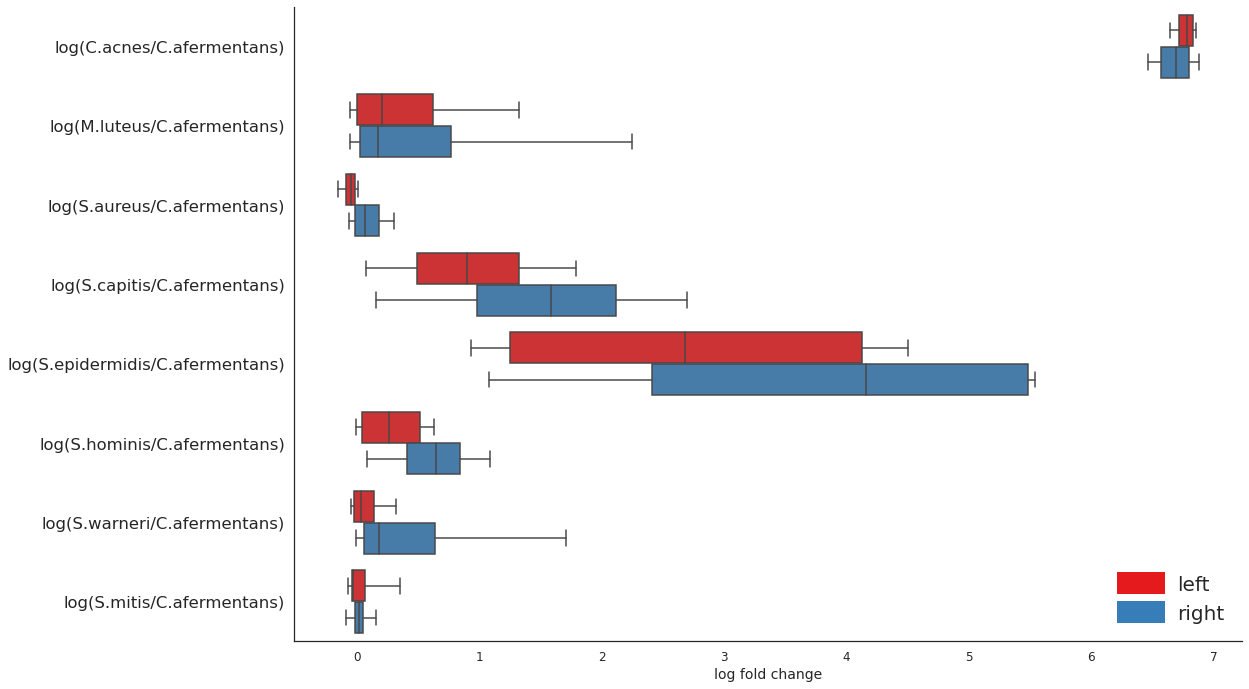

In [14]:
# load md
metadata = pd.read_table(f'{input_dir}/evonik_songbird_metadata.txt', index_col = 0)
metadata['chemical'] = np.where(metadata['Subject'].isin(['sub1', 'sub2', 'sub10', 'sub12', 'sub13']), 'SLES', 'RL')
metadata = metadata.sort_values('Subject')
metadata = metadata[(metadata['Time_Point'] == 'post') & (metadata['chemical'] == 'SLES') & (metadata['Subject'] != 'sub2')]

#load samples
table = load_table(f'{input_dir}/evonik_all_taxonomy_reformatted.biom').to_dataframe().T
table = table.loc[metadata.index.tolist(), syncom_strains]

# table normalization by column
table = table.loc[:, table.sum(axis=0)>0]
table = table.apply(lambda x: x / x.sum(), axis=1)

reference_species = 'Corynebacterium afermentans'

def balance_f(x):
    lr = [np.log(x['Cutibacterium acnes']+0.001) - np.log(x[reference_species]+0.001),
          np.log(x['Micrococcus luteus']+0.001) - np.log(x[reference_species]+0.001),
          np.log(x['Staphylococcus aureus']+0.001) - np.log(x[reference_species]+0.001),
          np.log(x['Staphylococcus capitis']+0.001) - np.log(x[reference_species]+0.001),
          np.log(x['Staphylococcus epidermidis']+0.001) - np.log(x[reference_species]+0.001),
          np.log(x['Staphylococcus hominis']+0.001) - np.log(x[reference_species]+0.001),
          np.log(x['Staphylococcus warneri']+0.001) - np.log(x[reference_species]+0.001),
          np.log(x['Streptococcus mitis']+0.001) - np.log(x[reference_species]+0.001)
         ]
    cols = [
        'log(C.acnes/C.afermentans)',
        'log(M.luteus/C.afermentans)',
        'log(S.aureus/C.afermentans)',
        'log(S.capitis/C.afermentans)',
        'log(S.epidermidis/C.afermentans)',
        'log(S.hominis/C.afermentans)',
        'log(S.warneri/C.afermentans)',
        'log(S.mitis/C.afermentans)'
    ]
    return pd.Series(lr, index=cols)

balances = table.apply(balance_f, axis = 1)

f = lambda x: paired_t_test(category='Control', md=metadata, df=x)[0]
tstats = balances.apply(f, axis=0)

f = lambda x: paired_t_test(category='Control', md=metadata, df=x)[1]
tpvals = balances.apply(f, axis=0)

f = lambda x: paired_t_test(category='Control', md=metadata, df=x)[2]
tlower = balances.apply(f, axis=0)

f = lambda x: paired_t_test(category='Control', md=metadata, df=x)[3]
tupper = balances.apply(f, axis=0)

stats = pd.DataFrame(
    {
        '24hControl_vs_24hChemical_tstat': tstats,
        '24hControl__vs_24hChemical_pvalue': tpvals,
        '24hControl_vs_24hChemical_upperCI': tlower,
        '24hControl_vs_24hChemical_lowerCI': tupper
    }
)

data = pd.merge(balances, metadata, left_index=True, right_index=True)

subdata = data[[
    'log(C.acnes/C.afermentans)',
    'log(M.luteus/C.afermentans)',
    'log(S.aureus/C.afermentans)',
    'log(S.capitis/C.afermentans)',
    'log(S.epidermidis/C.afermentans)',
    'log(S.hominis/C.afermentans)',
    'log(S.warneri/C.afermentans)',
    'log(S.mitis/C.afermentans)',
    'Control']]

df = pd.melt(subdata, id_vars = 'Control', var_name = 'balance')

# get the palette color name
deep_palette = sns.color_palette("Set1")

# Extract the first two colors
color1 = deep_palette[0]
color2 = deep_palette[1]

#, notch=True
sns.set(style="white", font_scale=1.5, font="sans-serif", palette="Set1")

# get a label for outlier,figure out why there is error bar 
# customize which counts as outlier
g = sns.catplot(x='value', y='balance', data=df, hue='Control', kind='box',
                hue_order=['left', 'right'], n_boot = 1000,
                height = 10, aspect = 1.8, legend = False, whis = [0,100])
g.set_xlabels('log fold change', fontsize=14)
g.set_ylabels('', fontsize=14)
plt.legend(fontsize = 20, frameon=False)
# plt.legend(loc='lower right', labels=['Control', 'Treatment'])
plt.legend(fontsize=20, frameon=False, loc='lower right')
plt.xticks(fontsize=12)

ax = plt.gca()
leg = ax.legend(fontsize=20, frameon=False, loc='lower right')
leg.legendHandles[0].set_linewidth(8)
leg.legendHandles[0].set_color(color1)
leg.legendHandles[1].set_linewidth(8)
leg.legendHandles[1].set_color(color2)
leg.get_frame().set_linewidth(0)
#plt.xticks(rotation=60)

# g.savefig('./out_sles/fig_sles.svg', format='svg')
# stats.to_csv('./out_c_afermentans/stats_day7_sles.csv')
stats

# RL

In [18]:
def paired_t_test(category, md, df):
    """ Performs paired t-test on a dataframe with complementing
    sample metadata.

    Parameters
    ----------
    category : str
       Category to test in the dataframe df
    md : pd.DataFrame
       Sample metadata specifying groupings
    df : pd.Dataframe
       Counts of microbes across all samples
              
    Returns
    -------
    T : float
       T-statistic
    prob : float
       p-value
    lower : float
       lower 95% CI bound
    upper : float
        upper 95% CI bound
    ddof : int
        degrees of freedom
    """
    cats = list(md[category].value_counts().index)
    src = md[md[category] == cats[1]].index
    print('***')
    print(src)
    dest = md[md[category] == cats[0]].index
    return ttest_rel(df.loc[dest].values, df.loc[src].values)

In [19]:
# load md
metadata = pd.read_table(f'{input_dir}/evonik_songbird_metadata.txt', index_col = 0)
metadata['chemical'] = np.where(metadata['Subject'].isin(['sub1', 'sub2', 'sub10', 'sub12', 'sub13']), 'SLES', 'RL')
metadata = metadata.sort_values('Subject')
metadata = metadata[(metadata['Time_Point'] == 'post') & (metadata['chemical'] == 'RL') & (metadata['Subject'] != 'sub3') & (metadata['Subject'] != 'sub4') & (metadata['Subject'] != 'sub7')]

#load samples
table = load_table(f'{input_dir}/evonik_all_taxonomy_reformatted.biom').to_dataframe().T
table = table.loc[metadata.index.tolist(), syncom_strains]

***
Index(['post_left_sub11_S16_WoL_index_filtered',
       'post_left_sub5_S12_WoL_index_filtered',
       'post_left_sub6_S13_WoL_index_filtered',
       'post_left_sub8_S14_WoL_index_filtered',
       'post_left_sub9_S110_WoL_index_filtered'],
      dtype='object', name='sampleid')
***
Index(['post_left_sub11_S16_WoL_index_filtered',
       'post_left_sub5_S12_WoL_index_filtered',
       'post_left_sub6_S13_WoL_index_filtered',
       'post_left_sub8_S14_WoL_index_filtered',
       'post_left_sub9_S110_WoL_index_filtered'],
      dtype='object', name='sampleid')
***
Index(['post_left_sub11_S16_WoL_index_filtered',
       'post_left_sub5_S12_WoL_index_filtered',
       'post_left_sub6_S13_WoL_index_filtered',
       'post_left_sub8_S14_WoL_index_filtered',
       'post_left_sub9_S110_WoL_index_filtered'],
      dtype='object', name='sampleid')
***
Index(['post_left_sub11_S16_WoL_index_filtered',
       'post_left_sub5_S12_WoL_index_filtered',
       'post_left_sub6_S13_WoL_index_filt

,24hControl_vs_24hChemical_tstat,24hControl__vs_24hChemical_pvalue,24hControl_vs_24hChemical_upperCI,24hControl_vs_24hChemical_lowerCI
log(C.acnes/C.afermentans),-0.346499,0.746428,-0.194093,0.151023
log(M.luteus/C.afermentans),-0.076048,0.943033,-0.463871,0.439137
log(S.aureus/C.afermentans),0.497989,0.644627,-0.174774,0.251172
log(S.capitis/C.afermentans),0.822257,0.457119,-0.438598,0.807692
log(S.epidermidis/C.afermentans),0.928363,0.405768,-0.307996,0.617433
log(S.hominis/C.afermentans),-0.700531,0.522202,-1.043407,0.622962
log(S.warneri/C.afermentans),1.669434,0.170354,-0.110073,0.442065
log(S.mitis/C.afermentans),-1.047233,0.354098,-1.786511,0.807928


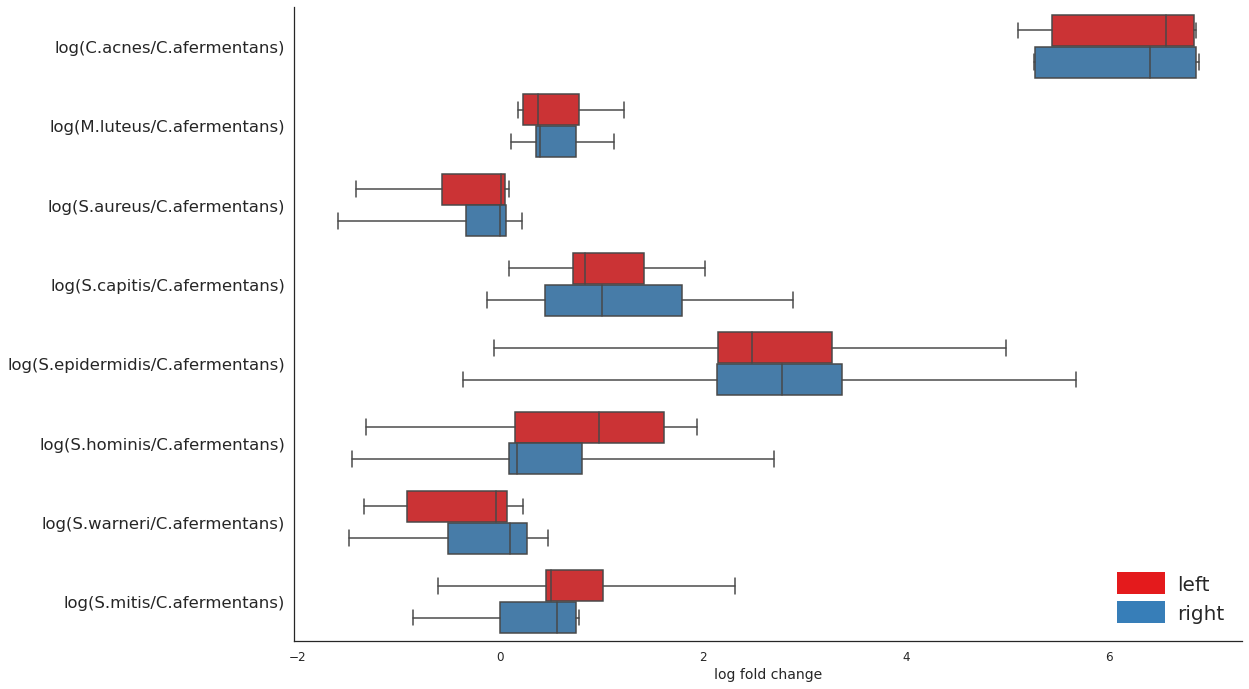

In [22]:
# table normalization by column
table = table.loc[:, table.sum(axis=0)>0]
table = table.apply(lambda x: x / x.sum(), axis=1)

reference_species = 'Corynebacterium afermentans'

def balance_f(x):
    lr = [np.log(x['Cutibacterium acnes']+0.001) - np.log(x[reference_species]+0.001),
          np.log(x['Micrococcus luteus']+0.001) - np.log(x[reference_species]+0.001),
          np.log(x['Staphylococcus aureus']+0.001) - np.log(x[reference_species]+0.001),
          np.log(x['Staphylococcus capitis']+0.001) - np.log(x[reference_species]+0.001),
          np.log(x['Staphylococcus epidermidis']+0.001) - np.log(x[reference_species]+0.001),
          np.log(x['Staphylococcus hominis']+0.001) - np.log(x[reference_species]+0.001),
          np.log(x['Staphylococcus warneri']+0.001) - np.log(x[reference_species]+0.001),
          np.log(x['Streptococcus mitis']+0.001) - np.log(x[reference_species]+0.001)
         ]
    cols = [
        'log(C.acnes/C.afermentans)',
        'log(M.luteus/C.afermentans)',
        'log(S.aureus/C.afermentans)',
        'log(S.capitis/C.afermentans)',
        'log(S.epidermidis/C.afermentans)',
        'log(S.hominis/C.afermentans)',
        'log(S.warneri/C.afermentans)',
        'log(S.mitis/C.afermentans)'
    ]
    return pd.Series(lr, index=cols)

balances = table.apply(balance_f, axis = 1)

f = lambda x: paired_t_test(category='Control', md=metadata, df=x)[0]
tstats = balances.apply(f, axis=0)

f = lambda x: paired_t_test(category='Control', md=metadata, df=x)[1]
tpvals = balances.apply(f, axis=0)

f = lambda x: paired_t_test(category='Control', md=metadata, df=x)[2]
tlower = balances.apply(f, axis=0)

f = lambda x: paired_t_test(category='Control', md=metadata, df=x)[3]
tupper = balances.apply(f, axis=0)

stats = pd.DataFrame(
    {
        '24hControl_vs_24hChemical_tstat': tstats,
        '24hControl__vs_24hChemical_pvalue': tpvals,
        '24hControl_vs_24hChemical_upperCI': tlower,
        '24hControl_vs_24hChemical_lowerCI': tupper
    }
)

data = pd.merge(balances, metadata, left_index=True, right_index=True)

subdata = data[[
    'log(C.acnes/C.afermentans)',
    'log(M.luteus/C.afermentans)',
    'log(S.aureus/C.afermentans)',
    'log(S.capitis/C.afermentans)',
    'log(S.epidermidis/C.afermentans)',
    'log(S.hominis/C.afermentans)',
    'log(S.warneri/C.afermentans)',
    'log(S.mitis/C.afermentans)',
    'Control']]

df = pd.melt(subdata, id_vars = 'Control', var_name = 'balance')

# get the palette color name
deep_palette = sns.color_palette("Set1")

# Extract the first two colors
color1 = deep_palette[0]
color2 = deep_palette[1]

#, notch=True
sns.set(style="white", font_scale=1.5, font="sans-serif", palette="Set1")

# get a label for outlier,figure out why there is error bar 
# customize which counts as outlier
g = sns.catplot(x='value', y='balance', data=df, hue='Control', kind='box',
                hue_order=['left', 'right'], n_boot = 1000,
                height = 10, aspect = 1.8, legend = False, whis = [0,100])
g.set_xlabels('log fold change', fontsize=14)
g.set_ylabels('', fontsize=14)
plt.legend(fontsize = 20, frameon=False)
# plt.legend(loc='lower right', labels=['Control', 'Treatment'])
plt.legend(fontsize=20, frameon=False, loc='lower right')
plt.xticks(fontsize=12)

ax = plt.gca()
leg = ax.legend(fontsize=20, frameon=False, loc='lower right')
leg.legendHandles[0].set_linewidth(8)
leg.legendHandles[0].set_color(color1)
leg.legendHandles[1].set_linewidth(8)
leg.legendHandles[1].set_color(color2)
leg.get_frame().set_linewidth(0)
#plt.xticks(rotation=60)

# g.savefig('./out_sles/fig_sles.svg', format='svg')
# stats.to_csv('./out_c_afermentans/stats_day7_rl.csv')
stats